# Twitter Sentiment Classification using Apache Spark

Initially the essential headers are imported from mllib. After the which the various functions that are going to be used in the code are defined.

The various functions and their functinalities are listed below:-

1) def remove_values_from_list(the_list, val) -Used for removing stop words from dirty data

2) def clean(filename) -The is the function that is used to clean data ie is from the train.csv and test.csv file before the data is being trained or tested.

3) def CompTF(tshuffle_rdd) -The HashingTF that is the term frequency is computed for a feature space of 25000

4) def CompTF_withNumFeatures(tshuffle_rdd) -The HashingTF that is the term frequency is computed for a feature space of 1500

5) def CompIDF(tf): -The IDF() computes the Inverse document frequency

6) def CompTFIDF(tf,idf): -Computes the tf-idf score to predict labels

7) def Convert_to_LabeledPoint(labels,features): -Converts a pair of labels and features into a Labeled Point

8) def NB_train(training): -Trains a dataset using the Naive Bayes Classifier

9) def LG_train(training): -Trains a dataset using the Logistic Regression Classifier

10) def DT_train(training): -Trains a dataset using the Decision Tree Learning Classifier

11) def test(model,labels,features): -Predicts labels based on the given features

12) def test_wpp(model,labels,features): -Predicts labels based on the given features and also returns the set of predicts probabilities(Only for Logistic Regression)

13) def test_final(model,labels,features): -Predicts labels based on the given features and returns predicted labels also for the purpose of calculation

In [13]:
%matplotlib inline
# If difficulty in import sc or SparkContext Manually
# Please uncomment the following to do so
#import pyspark
#sc = pyspark.SparkContext('local[*]')

from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import ChiSqSelector
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random

###############################################
# Removing Stop words

def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

##############################################
# Cleaning data

def clean(filename):
    text=open(filename, encoding='ISO-8859-1')
    file_reader = csv.reader(text)
    clean_final=[]
    c=0
    stop=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
    shuffle=[]
    tweet_list=[]
    for row in file_reader:
        temp_t=row[5]
        ts=temp_t.split(" ")
        for w in range(0,len(ts)):
            ts[w]=ts[w].lower()
            if (ts[w]!='' and ts[w][0]=='@'):
                ts[w]='AT_USER'
            if (ts[w]!='' and len(ts[w])>4  and ts[w][0]=='w' and ts[w][1]=='w' and ts[w][2]=='w' and ts[w][3]=='.'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>7  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]==':' and ts[w][5]=='/' and ts[w][6]=='/'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>8  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]=='s' and ts[w][5]==':' and ts[w][6]=='/' and ts[w][7]=='/'):
                ts[w]='URL'
            for i in range(0,len(ts[w])):
                flag=0
                if len(ts[w])>i+2 and ts[w][i]==ts[w][i+1] and ts[w][i]==ts[w][i+2]:
                    for j in range(i+2,len(ts[w])):
                        if ts[w][i]==ts[w][j]:
                            flag=1
                            if len(ts[w])>j+1 and ts[w][i]!=ts[w][j+1]:
                                break
                        if j==(len(ts[w]))-1 and ts[w][i]==ts[w][j]:
                            flag=1
                            break
                    if flag==1:
                        ts[w]=ts[w].replace(ts[w][i:j+1],ts[w][i])
            if (ts[w]!='' and ts[w][0].isdigit()):
                ts[w]=''
        for i in range(0,len(stop)):
            if stop[i] in ts:
                ts = remove_values_from_list(ts, stop[i])
        cleaned_list=[word.strip(string.punctuation) for word in ts]
        while '' in cleaned_list:
            cleaned_list.remove('')
        clean_final.append(cleaned_list)
        shuffle.append([row[0],cleaned_list])
        tweet_list.append(row[5])
    return (shuffle,tweet_list)


##############################################
#Compute TF

def CompTF(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(25000)
    tf = hashingTF.transform(t_rdd)
    return tf

def CompTF_withNumFeatures(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(1500)
    tf = hashingTF.transform(t_rdd)
    return tf

##############################################
#Compute IDF

def CompIDF(tf):
    tf.cache()
    idf = IDF().fit(tf)
    return idf

##############################################
#Compute TFIDF

def CompTFIDF(tf,idf):
    tfidf = idf.transform(tf)
    return tfidf

##############################################
#Feature Extraction

def Convert_to_LabeledPoint(labels,features):
    training = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))
    return training

##################################################
#Naive Bayes

#Training - NB
def NB_train(training):
    model = NaiveBayes.train(training)
    return model

###################################################
#Logistic Regression

#Training - LG
def LG_train(training):
    model = LogisticRegressionWithSGD.train(training,regType='l2')
    return model

#########################################
#Decision Trees

#Training - DT
def DT_train(training):
    model = DecisionTree.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={},
                                        impurity='gini', maxDepth=5, maxBins=32)
    return model

############################################
#Testing

def test(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return acc

##############################################
#Testing with pred prob

def test_wpp(model,labels,features):
    labels_and_probs = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs
    
#################################
#Final Test

def test_final(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return (labels_and_preds,acc)

#############################
# tpr and fpr

def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==1).count())
    true_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==0).count())
    false_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==0).count())
    false_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==1).count())

    tpr=(true_pos)/(true_pos+false_neg)
    fpr=(false_pos)/(false_pos+true_neg)
    return (tpr,fpr)

# Retrieving Data

Here the data from train.csv and test.csv is input into a list and clean and them converted to an RDD for further operations

In [14]:
########################################
# Read triaining data and split for CV


# Replace the path of train.csv in the "_____"    
train_shuffle,train_tweet_list=clean("train.csv")

random.shuffle(train_shuffle)

tshuff_rdd_train=sc.parallelize(train_shuffle)

p=tshuff_rdd_train.randomSplit(weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], seed=1)


#########################################
#test on test.csv(reading test.csv and classifying)

# Replace the path of test.csv in the "_____"
test_shuffle,test_tweet_list=clean("test.csv")

# Naive Bayes Classification

1) Here the Naive Bayes classifier is used for training the data testing it on the training data to obtain the TRAINING ACCURACY

2) After this the 10-fold Cross Validation is performed iteratvely to find the best classifier

3) Then training model is used and tested on the testing data to get the TEST ACCURACY

4) In addition to this we compute the Precision, Recall and F-1 Score for each label ie 1 and 0

5) We also compute the Average Precision, Recall and F-1 Score

6) The confusion matrix is also included

7) The Area under the ROC is computed

8) A graph which has plot of the training, 10-fold CV and test accuracy is also included

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 81.29125 %


10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for NB is 69.94343180389691 %
The accuracy for number 2 kth partition test for 10-fold cross validation for NB is 70.30079959385709 %
The accuracy for number 3 kth partition test for 10-fold cross validation for NB is 70.1230012300123 %
The accuracy for number 4 kth partition test for 10-fold cross validation for NB is 70.4225352112676 %
The accuracy for number 5 kth partition test for 10-fold cross validation for NB is 69.72292191435768 %
The accuracy for number 6 kth partition test for 10-fold cross validation for NB is 70.59265756170906 %
The accuracy for number 7 kth partition test for 10-fold cross validation for NB is 69.6159638554217 %
The accuracy for number 8 kth partition test for 10-fold cross validation for NB is 69.88967398041403 %
The accura

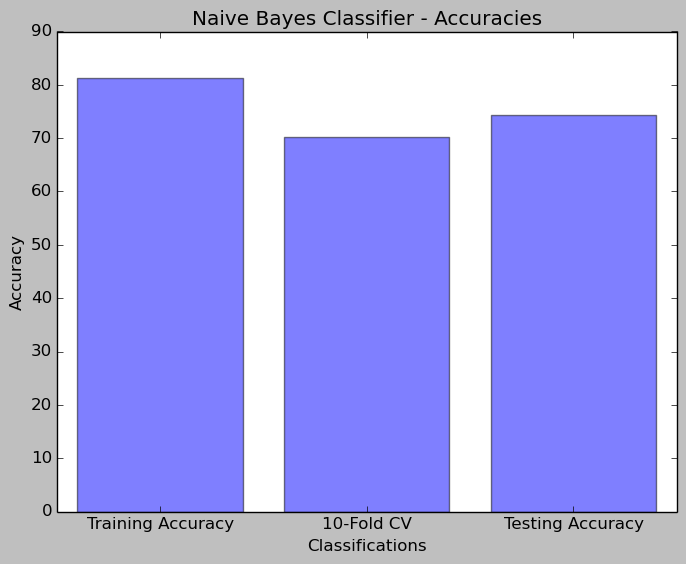


Summary Stats_NB

Class 0 precision_NB = 0.7456647398843931
Class 0 recall_NB = 0.7288135593220338
Class 0 F1 Measure_NB = 0.7371428571428571
Class 1 precision_NB = 0.7419354838709677
Class 1 recall_NB = 0.7582417582417582
Class 1 F1 Measure_NB = 0.75

Avg/Weighted recall_NB = 0.743732590529248
Avg/Weighted precision_NB = 0.7437741421282833
Avg/Weighted F(1) Score_NB = 0.7436609629924393

Confusion matrix_NB=
[[ 129.   48.]
 [  44.  138.]]


Area under ROC_NB = 0.7435276587818961


In [15]:
#######################################################
#Accuracy of Training data using train.csv itself using NB

tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)

###########################################
#Feature Extraction for training (train.csv) dataset

training_NB = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

############################################
#training accuracy for NB ML technique - training with training data

model_train_NB=NB_train(training_NB)

################################################
#testing NB with training data 

accuracy_NB=test(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

print ("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using NB is",accuracy_NB,"%")

print ("\n")
#################################################
# KFold NB

print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")


tot_NB_kfold=0
NB_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=NB_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for NB is",accuracy,"%")
    NB_kfold_set.append(accuracy)
    tot_NB_kfold=tot_NB_kfold+accuracy
avg_NB_kfold=tot_NB_kfold/len(p)
NB_kfold_best=max(NB_kfold_set)
print ("\n")
print ("The average accuracy for NB after 10-fold cross validation is",avg_NB_kfold,"%")
print ("\n")
print ("The highest accuracy for NB after 10-fold cross validation is",NB_kfold_best,"%")
print ("\n")



#print (test_shuffle)
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)



labels_and_preds_NB,accu_NB = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for NB on testing data is",accu_NB,"%")
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB,avg_NB_kfold,accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')
 
plt.show()

metrics = MulticlassMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s" % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)

# Logistic Regression and ROC curve

1) Here the Logistic Regression is used with L2 regularization for training the data testing it on the training data to obtain the TRAINING ACCURACY

2) After this the 10-fold Cross Validation is performed iteratvely to find the best classifier

3) Then training model is used and tested on the testing data to get the TEST ACCURACY

4) In addition to this we compute the Precision, Recall and F-1 Score for each label ie 1 and 0

5) We also compute the Average Precision, Recall and F-1 Score

6) The confusion matrix is also included

7) The Area under the ROC is computed

8) The ROC curve is also plotted

9) A graph which has plot of the training, 10-fold CV and test accuracy is also included


TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using LG is 76.11250000000001 %


10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for LG is 75.0345694531741 %
The accuracy for number 2 kth partition test for 10-fold cross validation for LG is 74.5399162330245 %
The accuracy for number 3 kth partition test for 10-fold cross validation for LG is 74.1820418204182 %
The accuracy for number 4 kth partition test for 10-fold cross validation for LG is 73.53337415799143 %
The accuracy for number 5 kth partition test for 10-fold cross validation for LG is 73.90428211586901 %
The accuracy for number 6 kth partition test for 10-fold cross validation for LG is 75.3915549429896 %
The accuracy for number 7 kth partition test for 10-fold cross validation for LG is 73.94578313253012 %
The accuracy for number 8 kth partition test for 10-fold cross validation for LG is 75.71587950911119 %
Th

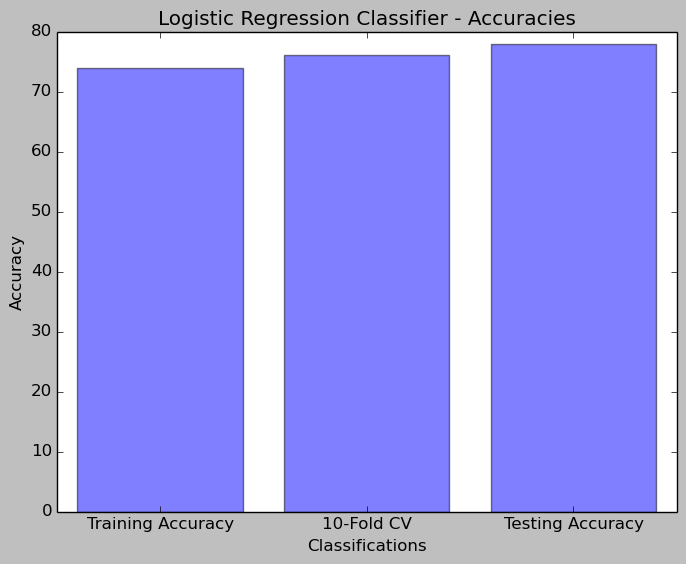


Summary Stats_LG

Class 0 precision_LG = 0.7456647398843931
Class 0 recall_LG = 0.7288135593220338
Class 0 F1 Measure_NB = 0.7371428571428571
Class 1 precision_LG = 0.7419354838709677
Class 1 recall_LG = 0.7582417582417582
Class 1 F1 Measure_NB = 0.75


Avg/Weighted recall_LG = 0.743732590529248
Avg/Weighted precision_LG = 0.7437741421282833
Avg/Weighted F(1) Score_LG = 0.7436609629924393

Confusion matrix_LG=
[[ 129.   48.]
 [  44.  138.]]



Area under ROC_LG = 0.7788539144471348


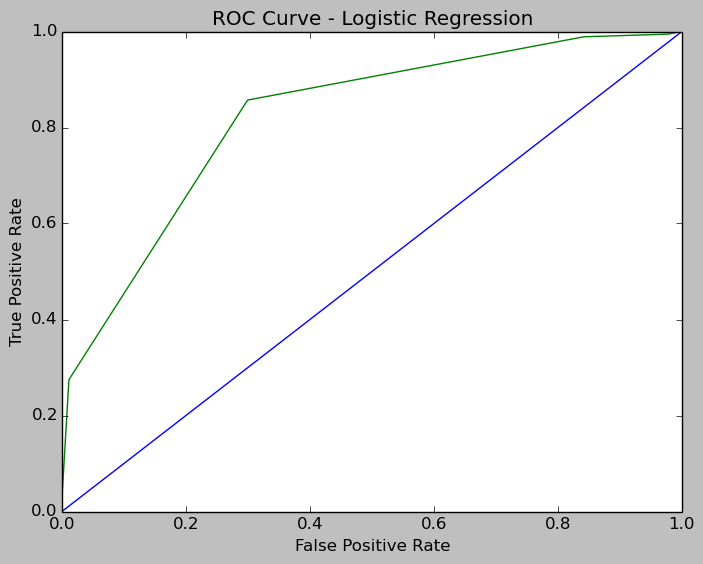

In [16]:
#######################################################
#Accuracy of Training data using train.csv itself using LG

tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_LG=LG_train(training)
accuracy=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using LG is",accuracy,"%")
print ("\n")

########################################################
# KFold LG

print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")


tot_LG_kfold=0
LG_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=LG_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy_LG=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for LG is",accuracy_LG,"%")
    tot_LG_kfold=tot_LG_kfold+accuracy
    LG_kfold_set.append(accuracy)
avg_LG_kfold=tot_LG_kfold/len(p)
LG_kfold_best=max(LG_kfold_set)
print ("\n")
print ("The average accuracy for LG after 10-fold cross validation is",avg_LG_kfold,"%")
print ("\n")
print ("The highest accuracy for LG after 10-fold cross validation is",LG_kfold_best,"%")
print ("\n")
#######################################################


tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)



labels_and_preds_LG,accu_LG = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for LG on testing data is",accu_LG,"%")
print ("\n")
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG,avg_LG_kfold,accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies')
 
plt.show()
#############################################################################################
# Statistics by class
print("\nSummary Stats_LG\n")
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\n\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n\n")

metrics2 = BinaryClassificationMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))



################################################################################################
# For ROC curve

model_train_LG.setThreshold(0.25)

labels_and_preds_LG2,accu_LG2 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

model_train_LG.setThreshold(0.75)
labels_and_preds_LG3,accu_LG3 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)


model_train_LG.setThreshold(0.1)

labels_and_preds_LG4,accu_LG4 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)


model_train_LG.setThreshold(0.9)

labels_and_preds_LG5,accu_LG5 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)


tpr,fpr=tf(labels_and_preds_LG) 
tpr2,fpr2=tf(labels_and_preds_LG2) 
tpr3,fpr3=tf(labels_and_preds_LG3)
tpr4,fpr4=tf(labels_and_preds_LG4) 
tpr5,fpr5=tf(labels_and_preds_LG5) 

x = [0,fpr5,fpr3,fpr,fpr2,fpr4,1]
y = [0,tpr5,tpr3,tpr,tpr2,tpr4,1]

# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.plot(x1,y1)
plt.plot(x,y)


################################################################################################
model_train_LG.clearThreshold()

labels_and_probs_LG=test_wpp(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))


# Area under ROC curve
print("Area under ROC_LG = %s" % metrics2.areaUnderROC)
plt.show()

# Decision Tree Learning

1) Here the Decision Tree Learning classifier is used for training the data testing it on the training data to obtain the TRAINING ACCURACY

2) After this the 10-fold Cross Validation is performed iteratvely to find the best classifier

3) Then training model is used and tested on the testing data to get the TEST ACCURACY

4) In addition to this we compute the Precision, Recall and F-1 Score for each label ie 1 and 0

5) We also compute the Average Precision, Recall and F-1 Score

6) The confusion matrix is also included

7) The Area under the ROC is computed

8) A graph which has plot of the training, 10-fold CV and test accuracy is also included


TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using DT is 62.07625 %


10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for DT is 62.58956631049655 %
The accuracy for number 2 kth partition test for 10-fold cross validation for DT is 62.901383424292426 %
The accuracy for number 3 kth partition test for 10-fold cross validation for DT is 61.45141451414514 %
The accuracy for number 4 kth partition test for 10-fold cross validation for DT is 61.45744029393754 %
The accuracy for number 5 kth partition test for 10-fold cross validation for DT is 62.0654911838791 %
The accuracy for number 6 kth partition test for 10-fold cross validation for DT is 62.16013030948503 %
The accuracy for number 7 kth partition test for 10-fold cross validation for DT is 61.6214859437751 %
The accuracy for number 8 kth partition test for 10-fold cross validation for DT is 61.69579769431015 %
The accu

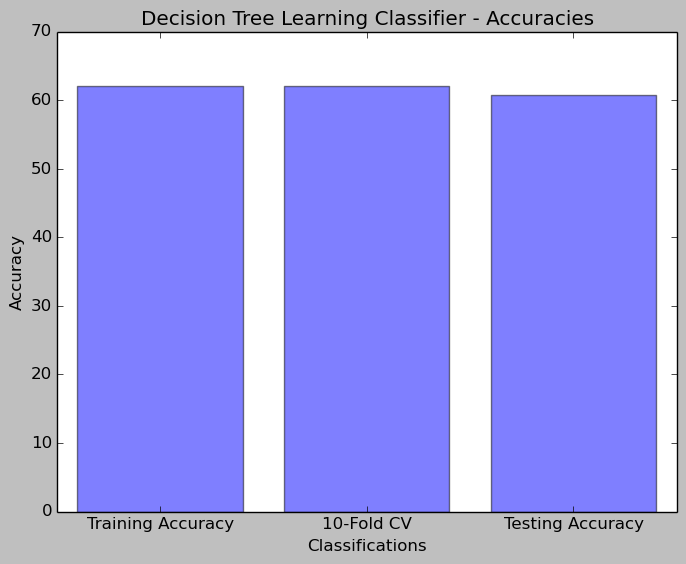


Summary Stats_D

Class 0 precision_DT = 0.5918367346938775
Class 0 recall_DT = 0.655367231638418
Class 0 F1 Measure_DT = 0.6219839142091153
Class 1 precision_DT = 0.6257668711656442
Class 1 recall_DT = 0.5604395604395604
Class 1 F1 Measure_DT = 0.5913043478260869


Avg/Weighted recall_DT = 0.607242339832869
Avg/Weighted precision_DT = 0.6090380852171687
Avg/Weighted F(1) Score_DT = 0.6064304850121482

Confusion matrix_DT=
[[ 116.   61.]
 [  80.  102.]]


In [17]:
#Accuracy of Training data using train.csv itself using DT
#print (test_shuffle)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_DT=DT_train(training)
accuracy_DT=test(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using DT is",accuracy_DT,"%")
print("\n")

########################################################
# KFold DT
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")

tot_DT_kfold=0
DT_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF_withNumFeatures(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train = DT_train(training)
    tf_test = CompTF_withNumFeatures(test_RDD)
    tfidf_test = CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for DT is",accuracy,"%")
    tot_DT_kfold=tot_DT_kfold+accuracy
    DT_kfold_set.append(accuracy)
avg_DT_kfold=tot_DT_kfold/len(p)
DT_kfold_best=max(DT_kfold_set)
print("\n")
print ("The average accuracy for DT after 10-fold cross validation is",avg_DT_kfold,"%")
print("\n")
print ("The highest accuracy for DT after 10-fold cross validation is",DT_kfold_best,"%")
print("\n")
    
################################################

tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF_withNumFeatures(tshuff_rdd_test)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)



labels_and_preds_DT,accu_DT = test_final(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for DT on testing data is",accu_DT,"%")
print("\n")
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_DT,avg_DT_kfold,accu_DT]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Classifier - Accuracies')
 
plt.show()
metrics = MulticlassMetrics(labels_and_preds_DT.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics

print("\nSummary Stats_D\n")


# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_DT = %s" % (label, metrics.precision(label)))
    print("Class %s recall_DT = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_DT = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\n\nAvg/Weighted recall_DT = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_DT = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_DT = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_DT=")
print(cm)

# Best Classifier

The best Classifier is calculated by finding the maximum out of the average and highest in the 10-fold Cross Validation.

# Fetching Tweets

Then after determining the best classifier we output the prediction probabilitioes and the corresponding tweet for Correctly and Incorrectly predicted label for tweets

# 20 Most Informative Features

For this part of the HW we have implemented 2 methods which are:-

1) We have used ChiSqSelector which is an inbuilt function of mllib, but this returns only hashed values

2) The next method involves, counting the features available in the training set and computing the number of 1's and 0's, then compute the weighted total of the numbers and then sort it in descending order and output the 20 most informative features

In [18]:
##############################################################################

maxi=max(float(avg_NB_kfold),float(avg_LG_kfold),float(avg_DT_kfold))
maxi_high=max(float(DT_kfold_best),float(LG_kfold_best),float(NB_kfold_best))

print ("Most accurate based on highest 10-fold CV accuracy:-\n")

if maxi_high==NB_kfold_best:
     print ("NB is the most accurate Classifier\n")
elif maxi_high==LG_kfold_best:
    print ("LG is the most accurate Classifier\n")
elif maxi_high==DT_kfold_best:
    print ("DT is the most accurate Classifier\n")

##############################################################################
    

print ("Most accurate based on average 10-fold CV accuracy:-\n")

if maxi==avg_NB_kfold:
    print ("NB is the most accurate Classifier")
    lpr= labels_and_preds_NB.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
elif maxi==avg_LG_kfold:
    print ("LG is the most accurate Classifier")
    lp=labels_and_probs_LG.map(lambda x:[x["probs"],x["actual"]])
    lp_list=[]
    for i in lp.collect():
        lp_list.append(i)
    pred=labels_and_preds_LG.map(lambda x:x["predicted"])
    pred_list=[]
    for i in pred.collect():
        pred_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorreclty along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    corr_tw_lg=[]
    incorr_tw_lg=[]
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            corr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            incorr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    
    corr_tw_lg=sorted(corr_tw_lg,key=lambda l:l[0], reverse=True)
    incorr_tw_lg=sorted(incorr_tw_lg,key=lambda l:l[0], reverse=True)
    
    print("******************************************************")
    c=0
    print("Correctly classified tweets sorted by probabilities are (LG):-\n")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",corr_tw_lg[i][1])
        print("prediction probability - ",corr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    print("******************************************************")
    c=0
    print("Incorrectly classified tweets sorted by probabilities are (LG):-")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",incorr_tw_lg[i][1])
        print ("prediction probability - ",incorr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    
elif maxi==avg_DT_kfold:
    print ("DT is the most accurate Classifier")
    lpr= labels_and_preds_DT.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    
else:
    print ("Error Occured")
                  
##############################################################################

training_chi = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tf_train)

selector = ChiSqSelector(20)

transformer = selector.fit(training_chi)

filteredData = (sc.parallelize([row[0] for row in tshuff_rdd_train.collect()])).zip(transformer.transform(tf_train)).map(lambda x: LabeledPoint(x[0], x[1]))

print ("\n\n20 Most Informative Features for the label 0.0 (According to ChiSqSelector)\n")
c=0
for i in filteredData.collect():
    if i.label==0.0:
        print (i.features)
        c=c+1
    if c==20:
        break
                  
print ("\n20 Most Informative Features for the label 1.0 (According to ChiSqSelector)\n")
c=0
for i in filteredData.collect():
    if i.label==1.0:
        print (i.features)
        c=c+1
    if c==20:
        break
        
print ("\n\n20 Most informative features(using own method)(On both labels ie. 0 and 1):-\n")
temp={}
c=0
for i in range(0,len(train_shuffle)):
    for j in range(0,len(train_shuffle[i][1])):
        if train_shuffle[i][1][j] in temp:
            if train_shuffle[i][0]=='1':
                temp[train_shuffle[i][1][j]][0]=temp[train_shuffle[i][1][j]][0]+1
                temp[train_shuffle[i][1][j]][1]=temp[train_shuffle[i][1][j]][1]+1
            elif train_shuffle[i][0]=='0':
                temp[train_shuffle[i][1][j]][0]=temp[train_shuffle[i][1][j]][0]+1
                temp[train_shuffle[i][1][j]][2]=temp[train_shuffle[i][1][j]][2]+1
        else:
            if train_shuffle[i][0]=='1': 
                temp[train_shuffle[i][1][j]]=[1,1,0]
            elif train_shuffle[i][0]=='0':
                temp[train_shuffle[i][1][j]]=[1,0,1]
temp2=[]
for k in temp:
    temp2.append([k,((0.33*temp[k][0])+(0.33*temp[k][1])+(0.33*temp[k][2]))])
temp2=sorted(temp2,key=lambda l:l[1], reverse=True)
c=0
for i in range(0,len(temp2)):
    print (i+1,") ",temp2[i][0])
    c=c+1
    if c==20:
        break


print ("_________________________")
############################################################################

Most accurate based on highest 10-fold CV accuracy:-

LG is the most accurate Classifier

Most accurate based on average 10-fold CV accuracy:-

LG is the most accurate Classifier
******************************************************
some test tweets that are classified correctly along with their prediction probabilities(LG):-

1 ) tweet -  @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.
prediction probability -  0.8174350003646305


2 ) tweet -  Reading my kindle2...  Love it... Lee childs is good read.
prediction probability -  0.8491361627917435


3 ) tweet -  Ok, first assesment of the #kindle2 ...it fucking rocks!!!
prediction probability -  0.5847126582116277


4 ) tweet -  @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
prediction probability -  0.548677908975344


5 ) tweet -  @mikefish  Fair enough. But i have the Kindle2 

# Naive Bayes ROC Curve

Here we have considered the training accuracy and the test accuracy as our ranks and plotted the ROC curve

(This may not be the correct way to plot the ROC curve for NB, there are no functions or methods in mllib to get the Prediction Probabilities or control the threshold, therefold we went ahead with this)

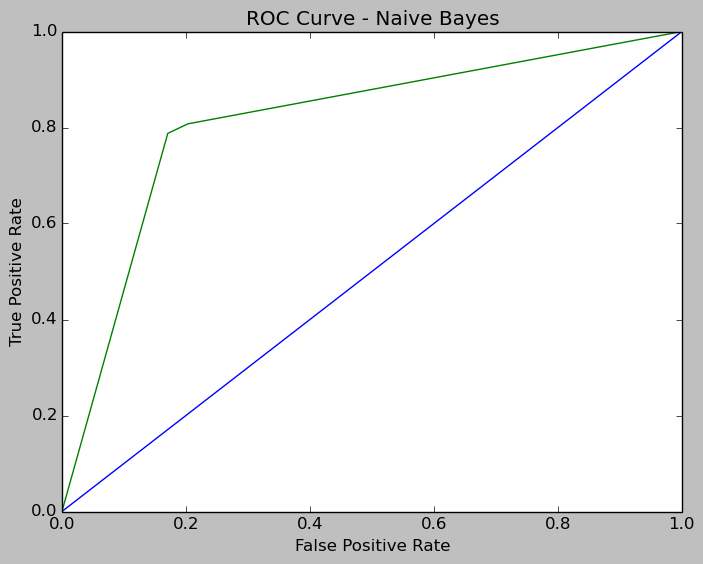

In [19]:
# For ROC Curve For NB using (Training data, Testing data)

#######################################################
#Accuracy of Training data using train.csv itself using NB

tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)

###########################################
#Feature Extraction for training (train.csv) dataset

training_NB = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tf_train)

############################################
#training accuracy for NB ML technique - training with training data

model_train_NB=NB_train(training_NB)

labels_and_preds_NB,accu_NB=test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

################################################
#testing NB with training data 

tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)

labels_and_preds_NB2,accu_NB2 = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tf_test)
tpr,fpr=tf(labels_and_preds_NB)
tpr2,fpr2=tf(labels_and_preds_NB2)
x = [0,fpr,fpr2,1]
y = [0,tpr,tpr2,1]
# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.plot(x1,y1)
plt.plot(x,y)
plt.show()